## Imports

In [13]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Processing Optimal results

In [14]:
large = False
if large:
    path = "/large"
else:
    path = ""

all_players = pd.read_csv("../data/optim-data" + path + "/0_selection_players.csv", index_col=0)
n_players = all_players.shape[0]

with open("../data/optim-data" + path + "/optim_solution.json", "r") as fp:
    solution = json.load(fp)
    fp.close()

solution_variables = solution['CPLEXSolution']['variables']
solution_variables = [(x['name'], float(x['value'])) for x in solution_variables]

In [15]:
def get_players(variables, identifier):
    # assign, lentout, borrowed
    players = [x[0] for x in variables if identifier in x[0]]
    players = [x.split("_")[1:] for x in players]
    
    return players

def get_player_info(all_players, players, info):
    return [all_players.loc[int(i), info] for i in players]

assigned = pd.DataFrame(get_players(solution_variables, 'assign'), columns = ['Player', 'Year'])
lentout = pd.DataFrame(get_players(solution_variables, 'lentout'), columns = ['Player', 'Year'])
borrowed = pd.DataFrame(get_players(solution_variables, 'borrowed'), columns = ['Player', 'Year'])

players = sorted(np.unique(np.concatenate([assigned.Player, lentout.Player, borrowed.Player])), key=lambda x: int(x))
player_name = get_player_info(all_players, players, 'Player')
ages = get_player_info(all_players, players, 'Age')
raritan = get_player_info(all_players, players, 'Raritan')
player_gk = get_player_info(all_players, players, 'GK')
player_fw = get_player_info(all_players, players, 'FW')
player_mf = get_player_info(all_players, players, 'MF')
player_df = get_player_info(all_players, players, 'DF')

In [16]:
def fill_assignment(assignment, variables, fill_val):
    
    for index, (playerid, year) in variables.iterrows():
        year_s = "Year" + str(year)
        assignment.loc[playerid, year_s] = fill_val
        
    return

years = ['Year' + str(x) for x in range(10)]
assignment = pd.DataFrame(np.full((10, len(players)), np.nan)).T
assignment.columns = years
assignment.index = players

fill_assignment(assignment, assigned, 'o')
fill_assignment(assignment, lentout, 'l')
fill_assignment(assignment, borrowed, 'b')

assignment

,Year0,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN
15,NaN,NaN,o,NaN,NaN,NaN,NaN,NaN,o,l
39,NaN,NaN,o,NaN,NaN,NaN,NaN,o,NaN,NaN
68,o,o,NaN,NaN,o,o,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2680,NaN,o,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2689,NaN,NaN,NaN,NaN,NaN,o,NaN,NaN,NaN,NaN
2701,NaN,NaN,NaN,o,NaN,NaN,NaN,NaN,NaN,NaN
2703,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b


In [17]:
player_info = pd.DataFrame([players, player_name, ages, raritan, player_gk, player_fw, player_mf, player_df]).T
player_info.columns = ["PlayerID", "Player", "Age0", "Raritan", 'GK', 'FW', 'MF', 'DF']
player_info.index = players
player_info

,PlayerID,Player,Age0,Raritan,GK,FW,MF,DF
1,1,a.acheng,24,0,0,0,0,1
13,13,a.avako,25,0,0,0,1,0
15,15,a.baguma,18,1,0,1,0,0
39,39,a.hasibuan,26,1,0,0,0,1
68,68,a.mtambo,28,1,0,0,0,1
...,...,...,...,...,...,...,...,...
2680,2680,z.moreira,24,1,0,1,0,0
2689,2689,z.nassolo,31,1,0,0,0,1
2701,2701,z.rajabi,30,1,0,0,0,1
2703,2703,z.rojas,21,0,0,0,0,1


In [18]:
player_selection = player_info.join(assignment, on='PlayerID')
player_selection
player_selection.to_excel("../data/optim-data" + path + "/selection.xlsx")


# Visualising Results

In [19]:
player_assignment_year = [player_selection.loc[:, year_s] for year_s in years]

/tmp/ipykernel_301/391399325.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


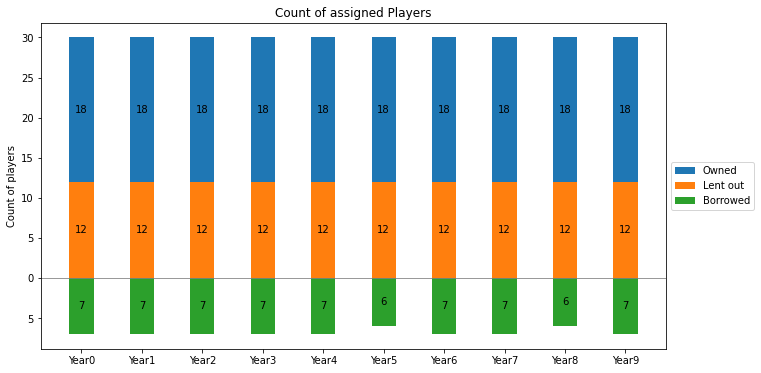

In [20]:
player_counts_year = [(np.sum(x == "o"), np.sum(x == "l"), np.sum(x == "b")) for x in player_assignment_year]

owned = [x[0] for x in player_counts_year]
lent = [x[1] for x in player_counts_year]
borrowed = [-x[2] for x in player_counts_year]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Count of players')
ax.set_title('Count of assigned Players')
ax.axhline(0, color='grey', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/tmp/ipykernel_301/2278060308.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


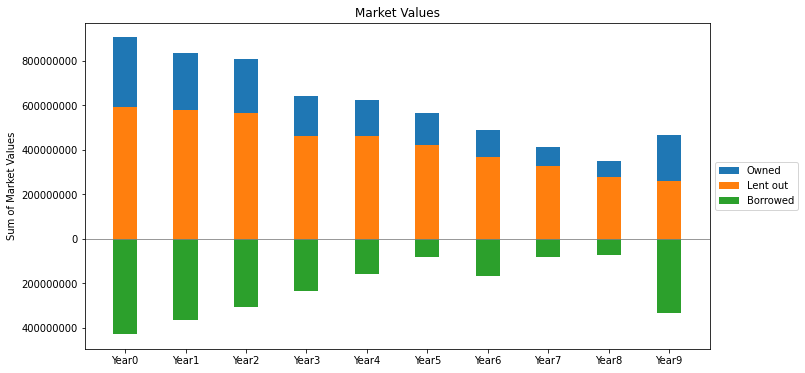

In [21]:
market_values = pd.read_csv("../data/optim-data/0_selection_mv.csv", index_col=0,).drop(['player_id', 'trial'], axis=1).values
n_time = market_values.shape[1]
n_trials = int(market_values.shape[0]/n_players)
market_values = np.median(market_values.reshape((n_trials, n_players, n_time)), axis=0)

owned = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'o']) for year, row in enumerate(player_assignment_year)]
lent = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'l']) for year, row in enumerate(player_assignment_year)]
borrowed = [-sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'b']) for year, row in enumerate(player_assignment_year)]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Sum of Market Values')
ax.set_title('Market Values')
ax.axhline(0, color='grey', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
# ax.bar_label(p1, label_type='center')
# ax.bar_label(p2, label_type='center')
# ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

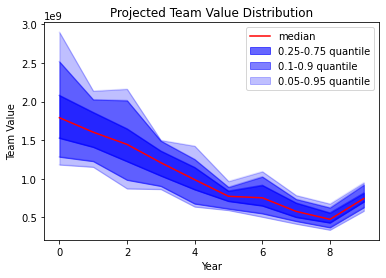

In [76]:
team_values = np.full((n_trials, n_time), np.nan)

for variable, val in solution_variables:
    if "Team Value" not in variable:
        continue
    tv = variable.split("_")
    year = int(tv[1])
    trial = int(tv[2])
    team_values[trial, year] = val

qs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
q_tv = np.quantile(team_values, qs, axis=0)

plt.title("Projected Team Value Distribution")
plt.xlabel("Year")
plt.ylabel("Team Value")

plt.plot(np.arange(n_time), q_tv[3, :], color ="red", label = 'median')

plt.plot(np.arange(n_time), q_tv[2, :], color ="blue", alpha =  0.5)
plt.plot(np.arange(n_time), q_tv[4, :], color ="blue", alpha =  0.5)
plt.fill_between(np.arange(n_time), q_tv[2,:], q_tv[4,:], color = 'blue', alpha =  0.6, label = "0.25-0.75 quantile")

plt.plot(np.arange(n_time), q_tv[1, :], color ="blue",alpha =  0.25)
plt.plot(np.arange(n_time), q_tv[5, :], color ="blue",alpha =  0.25)
plt.fill_between(np.arange(n_time), q_tv[1,:], q_tv[5,:], color = 'blue', alpha =  0.50, label = "0.1-0.9 quantile")


plt.plot(np.arange(n_time), q_tv[0, :], color ="blue",alpha =  0.10)
plt.plot(np.arange(n_time), q_tv[6, :], color ="blue",alpha =  0.10)
plt.fill_between(np.arange(n_time), q_tv[0,:], q_tv[6,:], color = 'blue', alpha =  0.25, label = "0.05-0.95 quantile")

plt.legend(loc='upper right')

plt.show()

# Comparison with other teams

In [17]:
benchmark_mv = pd.read_excel(r"..\data\optim-data\0_benchmark_mv.xlsx", "Top 5 Teams", index_col=0)
benchmark_mv[["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]] = benchmark_mv[["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]].apply(lambda x: x/benchmark_mv["Number of players"], axis = 0)
benchmark_mv = benchmark_mv.drop(["Number of players"], axis = 1)

In [13]:
plt.title("Projected Team Value Distribution")
plt.xlabel("Year")
plt.ylabel("Team Value")

plt.plot(np.arange(n_time), q_tv[3, :], color ="black")

plt.plot(np.arange(n_time), q_tv[2, :], color ="black")
plt.plot(np.arange(n_time), q_tv[4, :], color ="black")

plt.plot(np.arange(n_time), q_tv[1, :], color ="black")
plt.plot(np.arange(n_time), q_tv[5, :], color ="black")

plt.plot(np.arange(n_time), q_tv[0, :], color ="black")
plt.plot(np.arange(n_time), q_tv[6, :], color ="black")

plt.show()

,Team,Number of players,mv0,mv1,mv2,mv3,mv4,mv5,mv6,mv7,mv8,mv9
1,Sobianitedrucy,25,5.320400e+07,4.828600e+07,4.317400e+07,3.808600e+07,3.312000e+07,2.840400e+07,2.404400e+07,2.010000e+07,1.660600e+07,1.354000e+07
2,People's Land of Maneau,21,5.833333e+07,5.501905e+07,5.113810e+07,4.684762e+07,4.233333e+07,3.771905e+07,3.313810e+07,2.871429e+07,2.455238e+07,2.071905e+07
3,Nganion,21,4.780952e+07,4.411429e+07,4.015714e+07,3.604762e+07,3.192857e+07,2.788571e+07,2.402381e+07,2.042381e+07,1.716190e+07,1.421905e+07
4,Mico,21,2.342857e+07,2.161429e+07,1.964762e+07,1.758571e+07,1.550952e+07,1.348333e+07,1.157143e+07,9.773810e+06,8.150000e+06,6.700000e+06
5,Quewenia,20,2.274500e+07,2.084500e+07,1.883000e+07,1.674500e+07,1.468000e+07,1.269000e+07,1.081000e+07,9.090000e+06,7.535000e+06,6.175000e+06
6,Southern Ristan,24,3.079583e+07,2.797917e+07,2.507917e+07,2.223333e+07,1.948333e+07,1.687917e+07,1.448750e+07,1.230417e+07,1.035833e+07,8.654167e+06


# Budget

In [23]:
solution_variables

[('assign_15_2', 1.0),
 ('assign_15_8', 1.0),
 ('assign_15_9', 1.0),
 ('assign_39_2', 1.0),
 ('assign_39_7', 1.0),
 ('assign_68_0', 1.0),
 ('assign_68_1', 1.0),
 ('assign_68_4', 1.0),
 ('assign_68_5', 1.0),
 ('assign_81_1', 1.0),
 ('assign_81_9', 1.0),
 ('assign_95_3', 1.0),
 ('assign_107_5', 1.0),
 ('assign_118_0', 1.0),
 ('assign_118_1', 1.0),
 ('assign_118_2', 1.0),
 ('assign_118_3', 1.0),
 ('assign_118_4', 1.0),
 ('assign_118_5', 1.0),
 ('assign_118_6', 1.0),
 ('assign_118_7', 1.0),
 ('assign_118_8', 1.0),
 ('assign_118_9', 1.0),
 ('assign_143_0', 1.0),
 ('assign_143_3', 1.0),
 ('assign_143_4', 1.0),
 ('assign_143_5', 1.0),
 ('assign_143_7', 1.0),
 ('assign_143_8', 1.0),
 ('assign_143_9', 1.0),
 ('assign_168_0', 1.0),
 ('assign_168_1', 1.0),
 ('assign_168_4', 1.0),
 ('assign_170_7', 1.0),
 ('assign_177_6', 1.0),
 ('assign_190_0', 1.0),
 ('assign_190_1', 1.0),
 ('assign_190_2', 1.0),
 ('assign_190_3', 1.0),
 ('assign_190_4', 1.0),
 ('assign_190_5', 1.0),
 ('assign_190_6', 1.0),
 ('a